# Vietnamese Character Recognition Using Feature Selection

In this code, we explain the process of training a machine learning model to recognize Vietnamese characters. This model use our self generated data in 7 Vietnamese fonts. We also represent our method to select the feature, as well as in other steps of the machine learning process





## Table of content:
1. Data generating and preparing
2. Feature selection
3. Choosing model and model training
4. Model evaluation
5. Parameter tuning
6. Make prediction 

## 1. Data generating and preparing:
**Note: The code and explaination for data generation has been attached to this github project. For re-executing this file, veryone can reuse our data on Google Drive or generate a new version of it. Then they need to be uploaded to running session in Colab. This code below assume that data have been uploaded sucessfully**

*Create a directory and unrar our data*

In [1]:
!mkdir image_2900
!unrar x /content/image_2900.rar /content/image_2900


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/image_2900.rar

Creating    /content/image_2900/image_aug                             OK
Extracting  /content/image_2900/image_aug/image00000.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00001.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00002.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00003.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00004.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00005.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00006.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00007.jpg                   0%  OK 
Extracting  /content/image_2900/image_aug/image00008.jpg                   0%

In [3]:
!mkdir image_29k
!unrar x /content/image_29k.rar /content/image_29k

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  /content/image_29k/vietnamese_character_1k/image24002.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24003.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24004.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24005.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24006.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24007.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24008.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24009.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24010.jpg      83%  OK 
Extracting  /content/image_29k/vietnamese_character_1k/image24011.jpg      83%  OK 
Extracting  /

*Install dependence library and import them*

In [91]:
!pip install mahotas

from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm.classes import OneClassSVM
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import RadiusNeighborsClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier    
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from tensorflow.python.client import device_lib
from os import listdir
import os.path as osp
import cv2
from sklearn.decomposition import PCA
import numpy as np
import json
from matplotlib import pyplot as plt
import scipy.ndimage as ndi  
from scipy.spatial import distance
import mahotas as mt
import time


##2. Feature selection
We extract some features from features from our image, which include:  
* Aspect ratio
* Rectangularity
* Circularity
* Bounding elipse fit to character
* Contrast
* Correlation
* Entropy

In [75]:
def find_contour(image_path, is_visualize = False):
    main_img = cv2.imread(image_path)
    gs = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,170,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    contours, hierarchy = cv2.findContours(im_bw_otsu,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours.sort(key=len)
    contour = contours[len(contours)-1]

    if is_visualize == True:
        plt.subplot(131)
        plt.title('Original image')
        plt.imshow(main_img)

        plt.subplot(132)
        plt.title('Grey image')
        plottedContour = cv2.drawContours(gs,None,len(contours)-1,(0,255,0),5)
        #plt.imshow(closing)
        plt.imshow(plottedContour,cmap='Greys_r')

        plt.subplot(133)
        plt.title('Grey image with contour')
        plottedContour = cv2.drawContours(gs,contours,len(contours)-1,(0,255,0),5)
        #plt.imshow(closing)
        plt.imshow(plottedContour,cmap='Greys_r')

    return contour

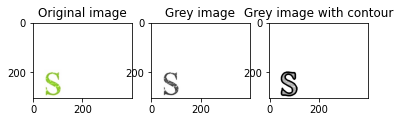

In [76]:
find_contour('/content/image_2900/image_aug/image02210.jpg',True);

In [31]:
def extract_features(image_path, vector_size=32):
    main_img = cv2.imread(image_path)
    gs = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    contour = find_contour(image_path)

    x = []
    _,__,w,h = cv2.boundingRect(contour)
    aspect_ratio = float(w)/h
    x.append(aspect_ratio)

    area = cv2.contourArea(contour)
    rectangularity = w*h/area
    x.append(rectangularity)

    perimeter = cv2.arcLength(contour,True)
    circularity = ((perimeter)**2)/area
    x.append(circularity)

    equi_diameter = np.sqrt(4*area/np.pi)
    (_,y),(MA,ma),angle = cv2.fitEllipse(contour)
    x.append(_)
    x.append(y)
    x.append(MA)
    x.append(ma)
    x.append(angle)
    
    textures = mt.features.haralick(gs)
    ht_mean = textures.mean(axis=0)
    for i in [1,2,4,8]:
      x.append(ht_mean[i])
    return np.array(x)

In [151]:
def load_data(path):
  X = []
  Y = []
  for file_path in listdir(path):
    Y.append(int(file_path[6:-4])//100)
    file_path = osp.join(path,file_path)
    instance = extract_features(file_path)
    X.append(instance)

  return np.array(X),np.array(Y)

In [159]:
start_time= time.time()
X, Y = load_data( '/content/image_2900/image_aug')
print('Time:{}'.format(time.time()-start_time))

Time:105.34748125076294


In [160]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

## 3. Choosing model and model training
Since it is a multi categorial classification problem, we try to use SVM (with polynomial kernel) and Decision Tree for it.

In [34]:
chars = ['a','ă','â','b','c','d','đ','e','ê','g','h','i','k','l','m','n','o','ô','ơ','p','q','r','s','t','u','ư','v','x','y']

In [79]:
DTC_clf = DecisionTreeClassifier(splitter='random',random_state=0)
DTC_clf = BaggingClassifier(clf, random_state=0).fit(X_train, Y_train)
#print("Performance on train set:{}\nPerformance on test set:{}".format(clf.score(X_train,Y_train),clf.score(X_test, Y_test)))

In [114]:
SVM_clf = svm.SVC(kernel='poly',decision_function_shape='ovo').fit(X_train, Y_train)
#print("Performance on train set:{}\nPerformance on test set:{}".format(SVM_clf.score(X_train,Y_train),SVM_clf.score(X_test, Y_test)))

## 4. Model evaluation
We use the mean accuracy metric to evaluate our model. We also show a confusion matrix of the classification



### SVM

In [115]:
print("Performance on train set:{}\nPerformance on test set:{}".format(SVM_clf.score(X_train,Y_train),SVM_clf.score(X_test, Y_test)))

Performance on train set:0.541871921182266
Performance on test set:0.4839080459770115


Confusion matrix


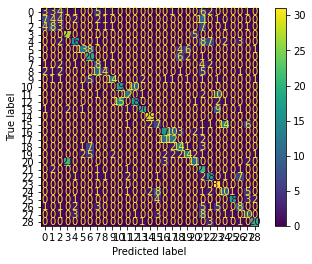

In [116]:
print("Confusion matrix")
plot_confusion_matrix(SVM_clf, X_test, Y_test)

### Decision Tree

In [87]:
print("Performance on train set:{}\nPerformance on test set:{}".format(DTC_clf.score(X_train,Y_train),DTC_clf.score(X_test, Y_test)))

Performance on train set:0.9881773399014778
Performance on test set:0.7885057471264367


Confusion matrix


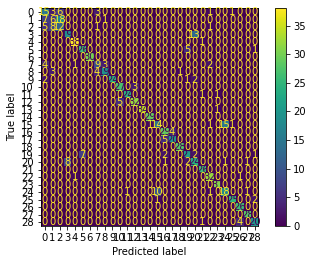

In [89]:
print("Confusion matrix")
plot_confusion_matrix(DTC_clf, X_test, Y_test)

**Observation:**  
* SVM: The accuracy score is low(54% on train set and 48% on test set). Consider its confusion matrix, the non-zero values gather mainly in the main diagonal, but many of them appear in many other place. The model is being underfit
* DTC: In the confusion matrix, we see that its non-zero value mainly appear in the main diagonal. The model work perfectly in the train set, but it is less efficient with the test set 

## 5. Parameter tuning
We tune the degree of polynomial for the support vector machine algorithm

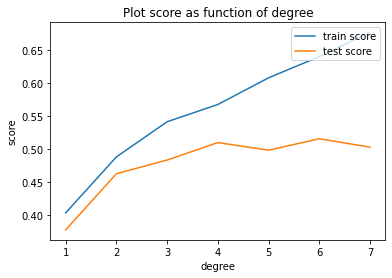

In [129]:
SVM_clf_set = []
degree_set = []
train_score_set = []
test_score_set = []
for degree in range(1,8):
  degree_set.append(degree)
  tmp_SVM_clf = svm.SVC(kernel='poly',degree=degree,decision_function_shape='ovo').fit(X_train, Y_train)
  SVM_clf_set.append(tmp_SVM_clf)
  train_score_set.append(tmp_SVM_clf.score(X_train, Y_train))
  test_score_set.append(tmp_SVM_clf.score(X_test, Y_test))
plt.title('Plot score as function of degree')
plt.plot(degree_set,train_score_set,degree_set,test_score_set)
#plt.plot(degree_set,test_score_set)
plt.legend(('train score','test score'),loc='upper right')
plt.xlabel('degree')
plt.ylabel('score')
plt.show()

We tune the depth for the decision tree algorithm

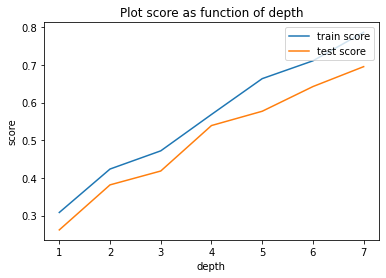

In [140]:
DTC_clf_set = []
depth_set = []
train_score_set = []
test_score_set = []
for depth in range(1,8):
  depth_set.append(depth)
  tmp_DTC_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=depth,splitter='random',random_state=0), 
                                  random_state=0).fit(X_train, Y_train)
  DTC_clf_set.append(tmp_DTC_clf)
  train_score_set.append(tmp_DTC_clf.score(X_train, Y_train))
  test_score_set.append(tmp_DTC_clf.score(X_test, Y_test))
plt.title('Plot score as function of depth')
plt.plot(degree_set,train_score_set,depth_set,test_score_set)
#plt.plot(degree_set,test_score_set)
plt.legend(('train score','test score'),loc='upper right')
plt.xlabel('depth')
plt.ylabel('score')
plt.show()

**Observation:**  
* SVM: The train score increases when the degree increases. The test set also increase and then stop at about 53%
* DTC: Both the score on train set and test set increase. But there is always a gap between them. The model cannot learn more on this training set


## 6. Make prediction:

In [149]:
def Predict(path):
  instance = extract_features(path)
  instance = np.array(instance)
  instance = instance.reshape(1,instance.shape[0])
  prediction = clf.predict(instance)
  plt.imshow(cv2.imread(path))
  print("Xin mạnh dạn dự đoán đây là chữ " + chars[prediction[0]])

Xin mạnh dạn dự đoán đây là chữ s


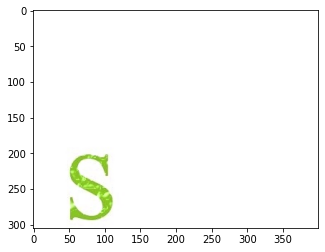

In [150]:
Predict('/content/image_2900/image_aug/image02210.jpg')